In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [7]:
# Set up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# MNIST
input_size = 784  # 28 * 28
hidden_size = 100
num_classes = 10  # 0 to 9

num_epochs = 2
batch_size = 100
learning_rate = 0.001

torch.Size([100, 1, 28, 28]) torch.Size([100])


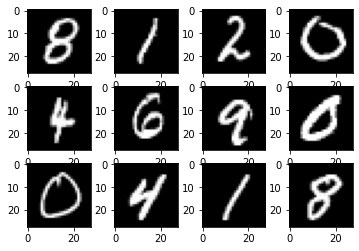

In [8]:
train_dataset = torchvision.datasets.MNIST(root='./',
                                           transform=transforms.
                                           ToTensor(),
                                           train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./',
                                         transform= transforms.
                                         ToTensor(),
                                         train=False, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(samples[i][0], cmap='gray', )
plt.show()

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        
        self.linear1 = nn.Linear(input_size, hidden_size, device=device)
        self.relu = nn.ReLU()
        
        self.linear2 = nn.Linear(hidden_size, num_classes, device=device)
        
    def forward(self, X):
        out = self.linear1(X)
        out = self.relu(out)
        out = self.linear2(out)
        
        return out
    
model = NeuralNet(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_iters = len(train_loader)

# Training Loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape Image to size 28 * 28
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        
        # Forward Pass
        y_pred = model(images)
        
        # Loss
        loss = criterion(y_pred, labels)
        
        # Backward Pass
        loss.backward()        
        optimizer.step()        
        optimizer.zero_grad()
        
        if (i + 1) % 100 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Step: {i + 1}/{n_iters}, Loss: {loss.item():.4f}")
            
with torch.no_grad():
    num_correct = 0
    num_samples = 0

    for images, labels in test_loader:
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # Value(which we don't need), Index of max output = final class
        _, predictions = torch.max(outputs, dim=1)

        num_samples += labels.shape[0]
        num_correct += (predictions == labels).sum().item()

accuracy = (num_correct / num_samples) * 100.0
print(f"Accuracy: {accuracy}")
        

Epoch: 1/2, Step: 100/600, Loss: 0.4780
Epoch: 1/2, Step: 200/600, Loss: 0.4407
Epoch: 1/2, Step: 300/600, Loss: 0.3555
Epoch: 1/2, Step: 400/600, Loss: 0.2188
Epoch: 1/2, Step: 500/600, Loss: 0.2427
Epoch: 1/2, Step: 600/600, Loss: 0.2383
Epoch: 2/2, Step: 100/600, Loss: 0.2502
Epoch: 2/2, Step: 200/600, Loss: 0.1874
Epoch: 2/2, Step: 300/600, Loss: 0.1268
Epoch: 2/2, Step: 400/600, Loss: 0.1890
Epoch: 2/2, Step: 500/600, Loss: 0.2607
Epoch: 2/2, Step: 600/600, Loss: 0.1998
Accuracy: 95.17


In [10]:
device

device(type='cuda')